# SMS Spam detection using Machine Learning

This is the code written in Python for building the a Spam Detector using Machine Learning trained on the 'spam.csv' file from Kaggle. We start from importing the dataset to building models.

We start by importing the required libraries such as numpy, pandas, nltk, etc... then we import the dataset by using Pandas.
The 'stopwords' contains the common English words that we don't really need for our algorithm and we stem each words. Then we convert the texts to a feature vector so that we can fit them to a classifier

### Import the required library and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer

In [2]:
df = pd.read_csv('spam.csv')
df.head()

,Unnamed: 0,v1,v2
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Clean the text data

In [3]:
df = df.drop('Unnamed: 0',axis=1)
df = df.rename(columns={'v2': 'messages', 'v1': 'label'})
df['label'] = df['label'].replace('ham',0)
df['label'] = df['label'].replace('spam',1)

Let us build a function that can clean the data by removing special characters, extra spaces and stopwords and stemming all the words in the text. We also remove the unecessary column.

In [4]:
def clean_text_data(data):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    wn = WordNetLemmatizer()
    data = data.lower()
    #Remove special characters
    data = re.sub(r'[^0-9a-zA-Z]', ' ', data)
    #Remove extra spaces
    data = re.sub(r'\s+', ' ', data)
    #Remove stopwords
    data = " ".join(w for w in data.split() if w not in stop_words)
    #stemming the words
    #Perform Lemmatization then Stemming
    words = data.split()
    l = []
    for w in words:
        w = re.sub('ly$','',w)
        w = wn.lemmatize(w,pos='v')
        w = wn.lemmatize(w,pos='n')
        w = wn.lemmatize(w,pos='a')
        w = ps.stem(w)
        l.append(w)
    data = " ".join(w for w in l)
    #data = l
    return data

In [5]:
df['messages']=df['messages'].apply(clean_text_data)

In [6]:
df['label'].mean()

0.13406317300789664

In [7]:
# The class is imbalanced so the "accuracy" is not a good choice of classification metric
# We will evaluate the model with "precision","recall" and "f1"

## Model building

In [8]:
X =df['messages']
Y = df['label']

In [9]:
from sklearn.feature_extraction.text import HashingVectorizer
vec = HashingVectorizer()
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline,make_pipeline
f_selector = SelectFromModel(SGDClassifier(),threshold='mean')
preprocessor = Pipeline([('Vectorizer',vec),('Feature_Selector',f_selector)])

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)

In [11]:
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
def plot_learning_curve(model,X_train,Y_train,metrics="f1"):
    N,train_score,val_score=learning_curve(model,X_train,Y_train,scoring=metrics)
    plt.figure()
    plt.plot(N,train_score.mean(axis=1),color='orange',label='training score')
    plt.plot(N,val_score.mean(axis=1),color='blue',label='validation score')
    plt.title('Learning curve')
    plt.xlabel('Training Size')
    plt.ylabel(metrics)
    plt.legend()
    plt.grid()

def tune_hyperparameters(model,X_train,Y_train,grid,metrics="f1"):
    gs = GridSearchCV(model,param_grid=grid,scoring=metrics)
    gs.fit(X_train,Y_train)
    print('Best Score: ',gs.best_score_)
    print('Best parameters: ',gs.best_params_)
    return gs.best_estimator_

def classification_test(model,X_test,Y_test):
    y_pred = model.predict(X_test)
    print('------ Evaluation on the test set-----')
    print('CLASSIFICATION REPORT: \n')
    print(classification_report(Y_test,y_pred))
    plt.figure(figsize=(3,3))
    sns.heatmap(data=confusion_matrix(Y_test,y_pred),square=True,annot=True)

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
lr = make_pipeline(preprocessor,LogisticRegression(class_weight={0:1,1:3.89}))
lr.fit(X_train,Y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('Vectorizer', HashingVectorizer()),
                                 ('Feature_Selector',
                                  SelectFromModel(estimator=SGDClassifier(),
                                                  threshold='mean'))])),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 1, 1: 3.89}))])

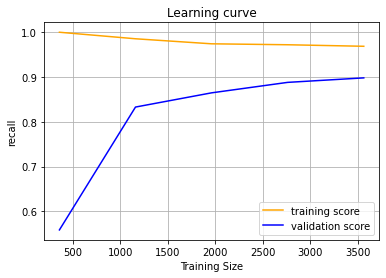

In [13]:
plot_learning_curve(lr,X_train,Y_train,metrics="recall")

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



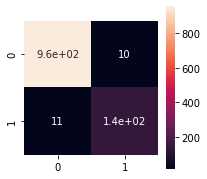

In [14]:
classification_test(lr,X_test,Y_test)

Best Score:  0.9030392156862744
Best parameters:  {'logisticregression__C': 2}


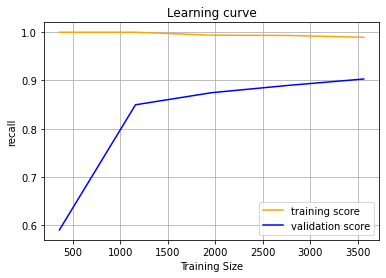

In [15]:
grid = {'logisticregression__C': [1,2,5,8]}
lr = tune_hyperparameters(lr,X_train,Y_train,grid,metrics='recall')
plot_learning_curve(lr,X_train,Y_train,metrics="recall")

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



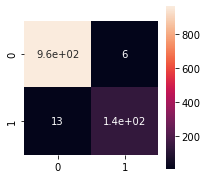

In [16]:
classification_test(lr,X_test,Y_test)

### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
dtc = make_pipeline(vec,f_selector,DecisionTreeClassifier(class_weight={0:1,1:3.89}))
dtc.fit(X_train,Y_train)

Pipeline(steps=[('hashingvectorizer', HashingVectorizer()),
                ('selectfrommodel',
                 SelectFromModel(estimator=SGDClassifier(), threshold='mean')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 3.89}))])

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       966
           1       0.79      0.89      0.84       149

    accuracy                           0.95      1115
   macro avg       0.89      0.93      0.90      1115
weighted avg       0.96      0.95      0.95      1115



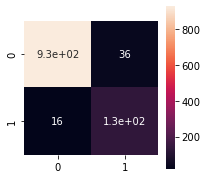

In [18]:
classification_test(dtc,X_test,Y_test)

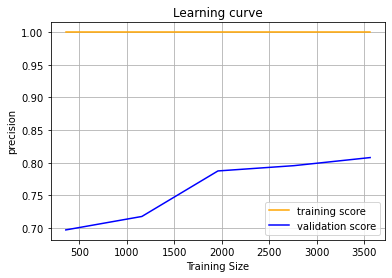

In [19]:
plot_learning_curve(dtc,X_train,Y_train,metrics='precision')

Best Score:  0.8230540563261874
Best parameters:  {'decisiontreeclassifier__max_depth': 25}


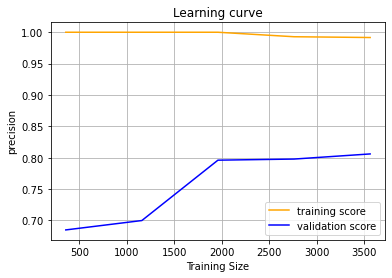

In [20]:
grid = {'decisiontreeclassifier__max_depth': [1,5,10,20,25,30]}
dtc = tune_hyperparameters(dtc,X_train,Y_train,grid,metrics='precision')
plot_learning_curve(dtc,X_train,Y_train,metrics='precision')

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       966
           1       0.79      0.91      0.84       149

    accuracy                           0.96      1115
   macro avg       0.89      0.93      0.91      1115
weighted avg       0.96      0.96      0.96      1115



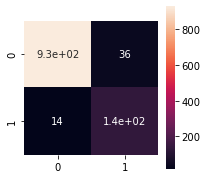

In [21]:
classification_test(dtc,X_test,Y_test)

### Support Vector Machine

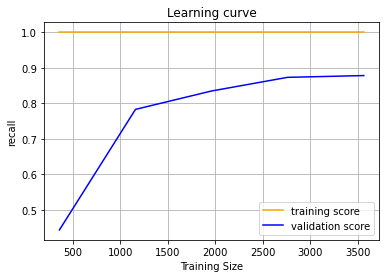

In [22]:
from sklearn.svm import SVC
svm = make_pipeline(vec,f_selector,SVC(kernel='rbf',C=1,gamma=1,class_weight={0:1,1:3.89}))
svm.fit(X_train,Y_train)
plot_learning_curve(svm,X_train,Y_train,metrics='recall')

Best Score:  0.934420854635373
Best parameters:  {'svc__C': 40, 'svc__gamma': 0.05}


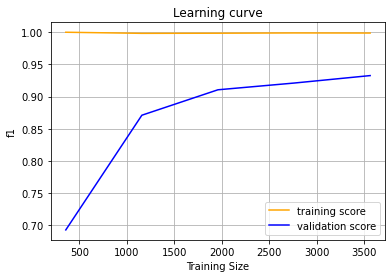

In [23]:
grid = {'svc__C':[40,45,70],'svc__gamma':[0.01,0.005,0.05]}
svm = tune_hyperparameters(svm,X_train,Y_train,grid,metrics='f1')
plot_learning_curve(svm,X_train,Y_train,metrics='f1')

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       1.00      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



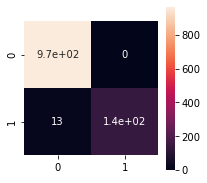

In [24]:
classification_test(svm,X_test,Y_test)

### Stacking Classifier

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
stc = StackingClassifier(estimators=[('LogisticRegression',lr),('SVM',svm),('DecisionTree',dtc)],final_estimator=KNeighborsClassifier())
stc.fit(X_train,Y_train)

StackingClassifier(estimators=[('LogisticRegression',
                                Pipeline(steps=[('pipeline',
                                                 Pipeline(steps=[('Vectorizer',
                                                                  HashingVectorizer()),
                                                                 ('Feature_Selector',
                                                                  SelectFromModel(estimator=SGDClassifier(),
                                                                                  threshold='mean'))])),
                                                ('logisticregression',
                                                 LogisticRegression(C=2,
                                                                    class_weight={0: 1,
                                                                                  1: 3.89}))])),
                               ('SVM',
                                Pipeline(steps=[('hashingvectorizer',
                                                 HashingVectori...
                                                                 threshold='mean')),
                                                ('svc',
                                                 SVC(C=40,
                                                     class_weight={0: 1,
                                                                   1: 3.89},
                                                     gamma=0.05))])),
                               ('DecisionTree',
                                Pipeline(steps=[('hashingvectorizer',
                                                 HashingVectorizer()),
                                                ('selectfrommodel',
                                                 SelectFromModel(estimator=SGDClassifier(),
                                                                 threshold='mean')),
                                                ('decisiontreeclassifier',
                                                 DecisionTreeClassifier(class_weight={0: 1,
                                                                                      1: 3.89},
                                                                        max_depth=25))]))],
                   final_estimator=KNeighborsClassifier())

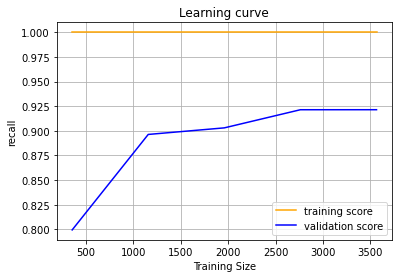

In [134]:
plot_learning_curve(stc,X_train,Y_train,'recall')

------ Evaluation on the test set-----
CLASSIFICATION REPORT: 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



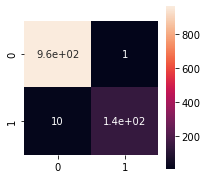

In [27]:
classification_test(stc,X_test,Y_test)

## Conclusion
* The models didn't overfit the training set
* The Support Vector Machine and Logistic Regression are our best candidate for this classification task
* The Stacked model performs well above the three model trained

# Save the model as a pickle file

In [28]:
import pickle
def save_model(model,file_name):
	pickl = {'model':model}	
	pickle.dump(pickl,open(file_name+".p","wb"))
    
def load_models(file_name):
	with open(file_name,'rb') as pickled:
		data = pickle.load(pickled)
		model = data['model']
	return model

We are going to save the model by building a pipeline of combining the "Vectorizer" with the "Models" because we need it later for building the web app
Now lets build a "Function transformer" for the SCIKIT-LEARN MODEL capable of cleaning all the input data.

In [29]:
from sklearn.preprocessing import FunctionTransformer
def text_cleaner(text):
    return [clean_text_data(text)]

cleaner = FunctionTransformer(func=text_cleaner)

In [30]:
final_model1 = Pipeline([('Text cleaner',cleaner),('LR_Pipeline',lr)])
final_model2 = Pipeline([('Text cleaner',cleaner),('SVM_Pipeline',svm)])
final_model3 = Pipeline([('Text cleaner',cleaner),('Stack_Pipeline',stc)])

In [31]:
save_model(final_model1,'lr')
save_model(final_model2,'svm')
save_model(final_model3,'stc')

In [32]:
X_test.to_csv('X_test.csv')